In [48]:
import os, sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# Dataset, dataloader
import torch.utils.data as Data
from torchvision import transforms

# Model
import torch.nn as nn
import torch.nn.functional as F

# Training
from torch.autograd import Variable

# Progress bar
from tqdm import tqdm

# Save file
from datetime import date

# Confusion Matrix
import sklearn.metrics as skm

# import from parent dir
sys.path.insert(1, os.path.realpath(os.path.pardir))    #sys.path.append('../')
from utils import read_json, prepare_device, ROOT_DIR
import data_loader.data_loaders as module_data
import model.model as module_arch
import model.loss as module_loss
import model.metric as module_metric
from parse_config import ConfigParser
from trainer import Trainer
from base import BaseModel

import warnings
warnings.filterwarnings('ignore')

In [2]:
par_dir = os.path.realpath(os.path.pardir)
cur_dir = os.getcwd()
csv_dir = os.path.join(ROOT_DIR, 'data', 'train_pivot.csv')

print("Parent dir: {}".format(par_dir))
print("Current dir: {}".format(cur_dir))
print('Root dir: {}'.format(ROOT_DIR))
print('Img dir: {}'.format(csv_dir))

Parent dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch
Current dir: d:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\notebook
Root dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..
Img dir: D:\jupyter-notebook\Kaggle\Steel-Defect-Detection-Pytorch\utils\..\data\train_pivot.csv


In [3]:
# testing if dir is correct
pd.read_csv(csv_dir)

,ImageId,1,2,3,4
0,0002cc93b.jpg,True,False,False,False
1,0007a71bf.jpg,False,False,True,False
2,000a4bcdd.jpg,True,False,False,False
3,000f6bf48.jpg,False,False,False,True
4,0014fce06.jpg,False,False,True,False
...,...,...,...,...,...
6661,ffcf72ecf.jpg,False,False,True,False
6662,fff02e9c5.jpg,False,False,True,False
6663,fffe98443.jpg,False,False,True,False
6664,ffff4eaa8.jpg,False,False,True,False


In [33]:
# load config.json
config = ConfigParser(config=read_json(os.path.join(par_dir, 'config.json')))

# load dataloader
data_loader = config.init_obj('data_loader', module_data)
train_loader = data_loader.train_loader
val_loader = data_loader.val_loader

# load model
model = config.init_obj('arch', module_arch)
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# load function handles of loss and metrics
criterion = getattr(module_loss, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# load optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

# Load Trainer
trainer = Trainer(model, criterion, metrics, optimizer,
                    config=config,
                    device=device,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    lr_scheduler=lr_scheduler)

# Start training
#trainer.train()

In [14]:
# view the layers of model
for i, child in enumerate(model.children()):
    print(i,child)

0 BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1 Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
2 Sequential(
  (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
3 Sequential(
  (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
4 Sequential(
  (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [47]:
# extra a layer from another model
l0 = list(model.children())[0]
l1 = nn.Sequential(*list(model.children())[1])

print(f'0: {l0}')
print(f'1: {l1}')

0: BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
1: Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)


In [46]:
list(model.children())[0].weight

Parameter containing:
tensor([0.], device='cuda:0')

In [35]:
# freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [41]:
# check if layers were frozen
for param in model.parameters():
    assert param.requires_grad==False
    print(param)

Parameter containing:
tensor([1.], device='cuda:0')
Parameter containing:
tensor([0.], device='cuda:0')
Parameter containing:
tensor([[[[-3.7918e-02,  1.1882e-01,  1.2827e-01, -6.0389e-02,  1.1130e-01],
          [-1.4868e-01,  2.7413e-03, -6.7940e-02,  1.0191e-01,  1.7007e-01],
          [ 4.3315e-02, -1.2217e-01,  9.2987e-02,  1.4967e-01,  9.0611e-02],
          [ 2.2924e-02, -1.6367e-01,  8.8665e-02,  1.1638e-01, -7.3374e-02],
          [ 1.0470e-01, -4.3694e-02,  2.4411e-02,  3.5586e-02, -1.6268e-01]]],


        [[[ 1.9351e-01,  1.3134e-01,  7.5755e-02, -9.3943e-02, -3.5310e-02],
          [-1.1995e-01, -1.5989e-01,  5.2446e-02, -1.6526e-01, -4.4992e-02],
          [ 1.2262e-01, -1.7988e-01, -1.9114e-02,  5.4895e-03, -1.9805e-01],
          [ 1.8281e-01, -1.5594e-01, -1.2225e-01,  7.4934e-02,  5.2519e-02],
          [-3.5858e-02,  1.9070e-01, -1.6379e-01, -2.0828e-02, -1.5673e-02]]],


        [[[ 8.7807e-02, -1.0620e-01, -1.8998e-02,  1.7343e-01,  5.6017e-02],
          [ 6.0263e

In [ ]:
class CNN2(BaseModel):        
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.bn_input = nn.BatchNorm2d(1)   # BN for input data first

        self.conv1 = conv_block(in_channels, 32)
        self.conv2 = conv_block(32, 64, pool=True)
        self.conv3 = conv_block(64, 128, pool=True)
        self.conv4 = conv_block(128, 256, pool=True)
        self.conv5 = conv_block(256, 256, pool=True)

        self.linear1 = nn.Linear(256*16*16, 512)   # (256*16*16, 512)
        #self.bn1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(512*16*16, 512),     # (512*16*100, 512)
        #     nn.Dropout(0.2),
        #     nn.Linear(512, num_classes),
        #     nn.BatchNorm1d(num_classes),    # BN before activation
        #     nn.Sigmoid()
        # )

    def forward(self, x):           # (batch_size, 1, 256, 256)
        x = self.conv1(x)           # (batch_size, 32, 256, 256)
        x = self.conv2(x)           # (batch_size, 64, 128, 128)
        x = self.conv3(x)           # (batch_size, 128, 64, 64)
        x = self.conv4(x)           # (batch_size, 256, 32, 32)
        x = self.conv5(x)           # (batch_size, 256, 16, 16)
        x = x.view(x.size(0), -1)   # (batch_size, 256*16*16)   cannot use flatten here which will be (batch_size*256*16*16)
        x = F.relu(self.linear1(x), inplace=True)
        out = torch.sigmoid(self.bn2(self.linear2(x)))
        #out = self.classifier(x)    # (512 * 16 * 100) -> (512) -> (4)
        return out.float()          # sigmoid [0 1]: return a probabilty of each class

In [54]:
def draw_loss_metric(history):
        '''
            Plot train_loss, val_loss, val_acc every epoch end
        '''
        
        plt.ion()
        #fig, axs = plt.subplots(2,1, figsize=(12,10))
        axs[0].clear()
        axs[0].set_title("train_loss vs val_loss")
        axs[0].plot(history['epoch'], history['train_loss'])
        axs[0].plot(history['epoch'], history['val_loss'])
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend(['train_loss', 'val_loss'], loc='upper right')

        axs[1].clear()
        axs[1].set_title('accuracy')
        axs[1].plot(history['epoch'], history['val_accuracy'])
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('accuracy')
            
        #fig.canvas.draw()
        #plt.show()
        
        #plt.show()
        plt.draw()
        plt.pause(.02)

history = pd.read_csv(os.path.join(ROOT_DIR, 'saved/log/Steel_Defect_Detection/0419_002114', 'history.csv'))

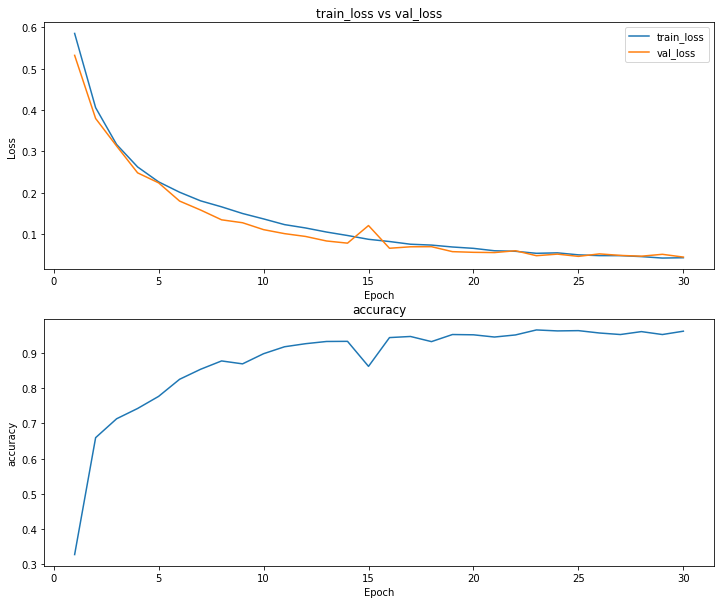

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [55]:
fig, axs = plt.subplots(2,1, figsize=(12,10))
for i in range(3):
    draw_loss_metric(history)